In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import csv, pickle
from tqdm.notebook import tqdm as tqdm
from functools import partial
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA

import numpy as np
import torch
import torch_geometric

In [82]:
import SORBET
import SORBET.data_handling as data_handling
import SORBET.learning as learning
from SORBET.learning.dataset import TorchOmicsDataset

# Load IMC Cohorts Data

In [4]:
excluded_markers = set(["Cell_131Xe_131Xe", "Cell_132Xe_132Xe", "Cell_200Hg_200Hg", "Cell_190BCKG_190BCKG"])
def load_c_patient(fpath, graph_label, excluded=excluded_markers):
    
    cell_list = list()
    edge_list = set()
    marker_list = list()
    
    make_edge = lambda i,j: tuple(sorted([i,j]))
    
    with open(fpath, 'r') as ifile:
        reader = csv.reader(ifile, delimiter=',')
        
        header = next(reader)
        neighbors_start_index = header.index('Number_Neighbors') + 1
        
        markers = header[2:35]
        marker_filt_list = [True if mi not in excluded else False for mi in markers]
        
        for row in reader:
            cell_id = int(row[1])
            cell_list.append(cell_id)
            
            cell_markers = list(map(float, row[2:35]))
            cell_markers = [float(mv) for mv, mfilt in zip(row[2:35], marker_filt_list) if mfilt]
            marker_list.append(cell_markers)
            
            neighbors = list(filter(lambda cid: cid != 0, (int(i) for i in row[neighbors_start_index:])))
            edge_list |= set(map(lambda nid: make_edge(nid, cell_id), neighbors))

    markers = [mi for mi, mfilt in zip(markers, marker_filt_list) if mfilt]
    return data_handling.OmicsGraph(cell_list, edge_list, np.array(marker_list), markers, graph_label)

In [5]:
for cnum in [1,2]:
    graph_mapping = dict()

    labels = list()

    output_dirpath = f"data/c{cnum}/graphs_py/complete/"
    if not os.path.exists(output_dirpath):
        os.makedirs(output_dirpath)

    responders_dirpath = f"data/c{cnum}/raw_data/DCB/"
    nonresponders_dirpath = f"data/c{cnum}/raw_data/NDB/"

    for ifile in os.listdir(responders_dirpath):
        gid = os.path.splitext(ifile)[0]
        data_graph = load_c_patient(os.path.join(responders_dirpath, ifile), 1)
        
        output_file = os.path.join(output_dirpath, f'{gid}.p')
        data_handling.dump_omicsgraph(data_graph, output_file)
        
        labels.append((gid, 1, "Responder", output_file))
        

    for ifile in os.listdir(nonresponders_dirpath):
        gid = os.path.splitext(ifile)[0]
        data_graph = load_c_patient(os.path.join(nonresponders_dirpath, ifile), 0)
        
        output_file = os.path.join(output_dirpath, f'{gid}.p')
        data_handling.dump_omicsgraph(data_graph, output_file)
        
        labels.append((gid, 0, "Responder", output_file))
        
        
    labels_fpath = f"data/c{cnum}/labels.csv"
    with open(labels_fpath, 'w+') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(["Graph ID", "Label", "Label Meaning", "Complete Graph"])
        writer.writerows(labels)
        
    print(len(labels))

29
41


In [6]:
for cnum in [1,2]:    
    complete_graphs_dirpath = f"data/c{cnum}/graphs_py/complete/"
    normalized_graphs_dirpath = f"data/c{cnum}/graphs_py/normalized/"
    lognormalized_graphs_dirpath = f"data/c{cnum}/graphs_py/lognormalized/"
    znormalized_graphs_dirpath = f"data/c{cnum}/graphs_py/znormalized/"
    rangenormalized_graphs_dirpath = f"data/c{cnum}/graphs_py/rangenormalized/"

    for d in [normalized_graphs_dirpath, lognormalized_graphs_dirpath, znormalized_graphs_dirpath, rangenormalized_graphs_dirpath]:
        if not os.path.exists(d): os.makedirs(d)

    for ifile in os.listdir(complete_graphs_dirpath):
        igraph_fpath = os.path.join(complete_graphs_dirpath, ifile)
        
        omics_graph = data_handling.load_omicsgraph(igraph_fpath)
        data_handling.normalize_graph(omics_graph, "total_count")
        data_handling.dump_omicsgraph(omics_graph, os.path.join(normalized_graphs_dirpath, ifile))
        
        omics_graph = data_handling.load_omicsgraph(igraph_fpath)
        data_handling.normalize_graph(omics_graph, "log_normalize")
        data_handling.dump_omicsgraph(omics_graph, os.path.join(lognormalized_graphs_dirpath, ifile))
    ofiles, log_graphs = list(), list()
    for ifile in os.listdir(lognormalized_graphs_dirpath):
        igraph_fpath = os.path.join(lognormalized_graphs_dirpath, ifile)
        omics_graph = data_handling.load_omicsgraph(igraph_fpath)
        log_graphs.append(omics_graph)

        ofiles.append(os.path.join(znormalized_graphs_dirpath, ifile))

    data_handling.normalize_dataset(log_graphs, "z-normalize")
    for ofile, graph in zip(ofiles, log_graphs):
        data_handling.dump_omicsgraph(graph, ofile)
    ofiles, log_graphs = list(), list()
    for ifile in os.listdir(lognormalized_graphs_dirpath):
        igraph_fpath = os.path.join(lognormalized_graphs_dirpath, ifile)
        omics_graph = data_handling.load_omicsgraph(igraph_fpath)
        log_graphs.append(omics_graph)

        ofiles.append(os.path.join(rangenormalized_graphs_dirpath, ifile))

    data_handling.normalize_dataset(log_graphs, "to-range")
    for ofile, graph in zip(ofiles, log_graphs):
        data_handling.dump_omicsgraph(graph, ofile)

In [46]:
def create_summaary_embeddings_dataset(input_dirpath, output_dirpath):
    for ifile in os.listdir(input_dirpath):
        igraph_fpath = os.path.join(input_dirpath, ifile)
        omics_graph = data_handling.load_omicsgraph(igraph_fpath)
        markers = omics_graph.markers
        # keep only the name after the last underscore
        markers = [m.split("_")[-1] for m in markers]
        node_data = omics_graph.get_node_data()
        cell_embedding = data_handling.create_summary_embedding(markers, node_data)
        omics_graph.set_node_data(cell_embedding, [f"cell_embedding_{i}" for i in range(cell_embedding.shape[1])])
        data_handling.dump_omicsgraph(omics_graph, os.path.join(output_dirpath, ifile))
        

In [49]:
for cnum in [1,2]:
    rangenormalized_graphs_dirpath = f"data/c{cnum}/graphs_py/rangenormalized/"
    rangenormalized_summary_graphs_dirpath = f"data/c{cnum}/graphs_py/rangenormalized_summary/"
    if not os.path.exists(rangenormalized_summary_graphs_dirpath): os.makedirs(rangenormalized_summary_graphs_dirpath)
    create_summaary_embeddings_dataset(rangenormalized_graphs_dirpath, rangenormalized_summary_graphs_dirpath)


In [50]:
def create_cell_sentenecs_dataset(input_dirpath, output_dirpath):
    for ifile in os.listdir(input_dirpath):
        igraph_fpath = os.path.join(input_dirpath, ifile)
        omics_graph = data_handling.load_omicsgraph(igraph_fpath)
        markers = omics_graph.markers
        # keep only the name after the last underscore
        markers = [m.split("_")[-1] for m in markers]
        node_data = omics_graph.get_node_data()
        cell_embedding = data_handling.get_cell_embeddings(node_data, markers)
        omics_graph.set_node_data(cell_embedding, [f"cell_embedding_{i}" for i in range(cell_embedding.shape[1])])
        data_handling.dump_omicsgraph(omics_graph, os.path.join(output_dirpath, ifile))

In [51]:
for cnum in [1,2]:
    rangenormalized_graphs_dirpath = f"data/c{cnum}/graphs_py/rangenormalized/"
    rangenormalized_cell_setences_dirpath = f"data/c{cnum}/graphs_py/rangenormalized_cell_sentences/"
    if not os.path.exists(rangenormalized_cell_setences_dirpath): os.makedirs(rangenormalized_cell_setences_dirpath)
    create_cell_sentenecs_dataset(rangenormalized_graphs_dirpath, rangenormalized_cell_setences_dirpath)
    

In [101]:
for cnum in [1,2]:    
    K = 10 # Neighborhood size
    MS = 50 # Minimum size
    anchor_marker = "Cell_148Nd_PANCK" if cnum == 1 else "Cell_148Nd_panCK"

    idirs = [f"data/c{cnum}/graphs_py/rangenormalized/",  f"data/c{cnum}/graphs_py/rangenormalized_summary/", f"data/c{cnum}/graphs_py/rangenormalized_cell_sentences/"]
    odir_names = ["original_subgraphs", "summary_subgraphs", "cell_sentence_subgraphs"]

    for idir, odirn in zip(idirs, odir_names):
        odir = f'data/c{cnum}/{odirn}'
        if not os.path.exists(odir):
            os.makedirs(odir)

        if odirn == "original_subgraphs":
            graphs_for_node_data_dirpath = None
        else:
            graphs_for_node_data_dirpath = idir
        data_handling.create_subgraphs(f"data/c{cnum}/graphs_py/rangenormalized/", odir, "microenvironment",  {"marker": anchor_marker, "k": K, "minimum_size":MS}, graphs_for_node_data_dirpath=graphs_for_node_data_dirpath)
        data_handling.create_torch_subgraphs(odir)

# Learning Phase

In [122]:
def report_and_visualize_results(results, model_type, metadata_files, root_fpath, logdir, tmp_kfold_split, labels_comb, preds_comb, model_name, input_dim):
    config = results.get_best_result(mode="max", metric="auroc").metrics['config']
    params, model_structure = learning.get_model_and_training_specifications(config, model_type, input_dim)
    print(params)
    fig, axes = plt.subplots(1,2,figsize=(10,5), sharey=True)
    auroc_results = []
    for spl_id, (train_ids, val_ids, test_ids) in enumerate(tqdm(tmp_kfold_split)):
        train_ds = learning.TorchOmicsDataset(root_fpath, metadata_files, train_ids)
        val_ds = learning.TorchOmicsDataset(root_fpath, metadata_files, val_ids)
        test_ds = learning.TorchOmicsDataset(root_fpath, metadata_files, test_ids)
        _, (preds, labs), acc, tl, vl = learning.train_model(model_type, model_structure, [train_ds, val_ds, test_ds], print_lvl=0, tensorboard_dir=logdir, **params)
        
        axes[0].plot(list(range(1,len(tl)+1)), [np.mean(a) for a in tl], label=f'Run {spl_id} - Train')
        axes[1].plot([t[0] for t in vl], [t[1] for t in vl], label=f'Run {spl_id} - Val')

        auroc = roc_auc_score(labs, preds)
        print(f'Split {spl_id} AUROC: {auroc:.3f}')
        auroc_results.append(auroc)
        labels_comb.extend(labs)
        preds_comb.extend(preds)

    axes[0].legend(loc='upper right')
    axes[1].legend(loc='upper right')
    plt.show()

    learning.plot_model_calibration(labels_comb, preds_comb); plt.show();
    learning.plot_combined_metrics([["GCN", preds_comb, labels_comb]]); plt.show();
    fig.savefig(f'{model_name}_training.png', dpi=300)
    return params, model_structure


In [123]:
def optimize_hyperparameters(cnum, path_to_data, model_name, input_dim):
    if cnum != 1 and cnum != 2:
        raise ValueError("cnum must be 1 or 2")
    path_to_data = path_to_data.format(cnum=cnum)
    print(path_to_data)
    if not os.path.exists(path_to_data):
        raise ValueError("path_to_data must be a valid path to the data")
    labels_fpath = f"data/c{cnum}/labels.csv"
    root_fpath = os.path.abspath("./")
    metadata_files = learning.make_subgraph_metadata(path_to_data)
    tmp_kfold_split = list(learning.stratified_kfold_split(labels_fpath, 5, include_validation=True))
    labels_comb, preds_comb = list(), list()

    logdir = os.path.abspath(f"runs/c{cnum}/test/{model_name}")

    model = learning.GCNSorbetBase
    hyperparamter_space = {
        # Training Hyperparamters:
        "epochs": [100],
        "learning_rate": [1e-4,9e-4],
        "batch_size": [64],
        "l1_penalty": [1e-4, 1e-2],
        "restarts": [1],
        # Model Structure Hyperparamters:
        "in_linear_channels": [2, 3, 70, 100],
        "conv_channels": [2, 3,  70, 100],
        "embedding_linear_channels": [1, 2,  70, 100],
        "out_linear_channels": [1, 2, 30, 100],
        "dropout": [0.3, 0.7],
        "pooling_fn": ["global_max"]
}

    results = learning.hyperparameter_optimization(
        tmp_kfold_split, root_fpath, metadata_files, input_dim, 
        model, hyperparamter_space, set_model = False, num_model_evals=40,
        n_cpus = 48, n_gpus = 8, allow_fractional = 0.5
    )
    return report_and_visualize_results(results, model, metadata_files, root_fpath, logdir, tmp_kfold_split, labels_comb, preds_comb, model_name, input_dim) 

In [124]:
def train_model_on_one_chort_and_test_on_the_other(cnum_to_train_on, path_to_data, model_name, input_dim):
    if cnum_to_train_on != 1 and cnum_to_train_on != 2:
        raise ValueError("cnum must be 1 or 2")
    cnum_to_test_on = 2 if cnum_to_train_on == 1 else 1
    params, model_structure = optimize_hyperparameters(cnum_to_train_on, path_to_data, model_name, input_dim)
    path_to_data_train = path_to_data.format(cnum=cnum_to_train_on)
    path_to_data_test = path_to_data.format(cnum=cnum_to_test_on)
    test_labels_fpath = f"data/c{cnum_to_test_on}/labels.csv"
    train_labels_fpath = f"data/c{cnum_to_train_on}/labels.csv"
    root_fpath = os.path.abspath("./")
    metadata_files_train = learning.make_subgraph_metadata(path_to_data_train)
    metadata_files_test = learning.make_subgraph_metadata(path_to_data_test)
    train_ids = learning.get_all_sample_ids(train_labels_fpath)
    test_ids = learning.get_all_sample_ids(test_labels_fpath)
    # get the whole dataset for training
    train_ds = TorchOmicsDataset(root_fpath, metadata_files_train, train_ids)
    test_ds = TorchOmicsDataset(root_fpath, metadata_files_test, test_ids)
    model = learning.GCNSorbetBase
    _, (preds, labs), acc, tl, vl = learning.train_model(model, model_structure, [train_ds, test_ds], print_lvl=0, tensorboard_dir=None, **params)
    fig, axes = plt.subplots(1,2,figsize=(10,5), sharey=True)
    learning.plot_model_calibration(labs, preds); plt.show();
    learning.plot_combined_metrics([[model_name, preds, labs]]); plt.show();
    fig.savefig(f'{model_name}_test.png', dpi=300)
    
    

2023-12-18 08:50:39,062	INFO tune.py:1148 -- Total run time: 1288.66 seconds (1288.61 seconds for the tuning loop).


{'epochs': 100, 'learning_rate': 0.0005241560828362777, 'batch_size': 64, 'restarts': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

Split 0 AUROC: 0.579
Split 1 AUROC: 0.844
Split 2 AUROC: 0.776
Split 3 AUROC: 1.000
Split 4 AUROC: 0.961


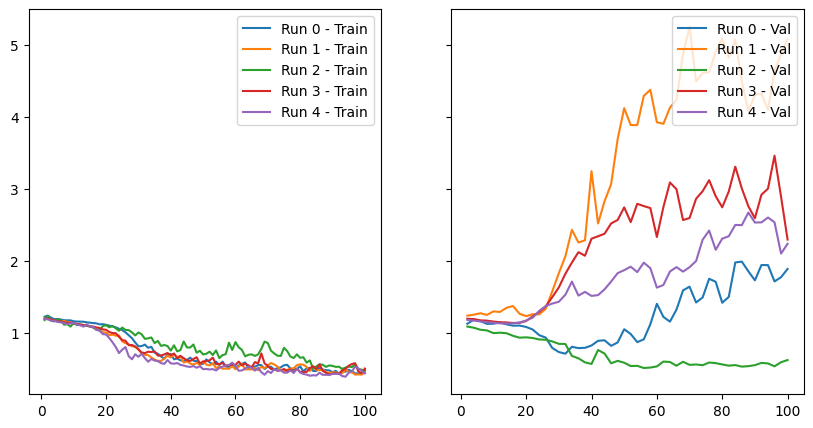

0.0 0.1 306
0.1 0.2 14
0.2 0.30000000000000004 10
0.30000000000000004 0.4 8
0.4 0.5 9
0.5 0.6000000000000001 11
0.6000000000000001 0.7000000000000001 13
0.7000000000000001 0.8 4
0.8 0.9 0
0.9 1.0 0


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


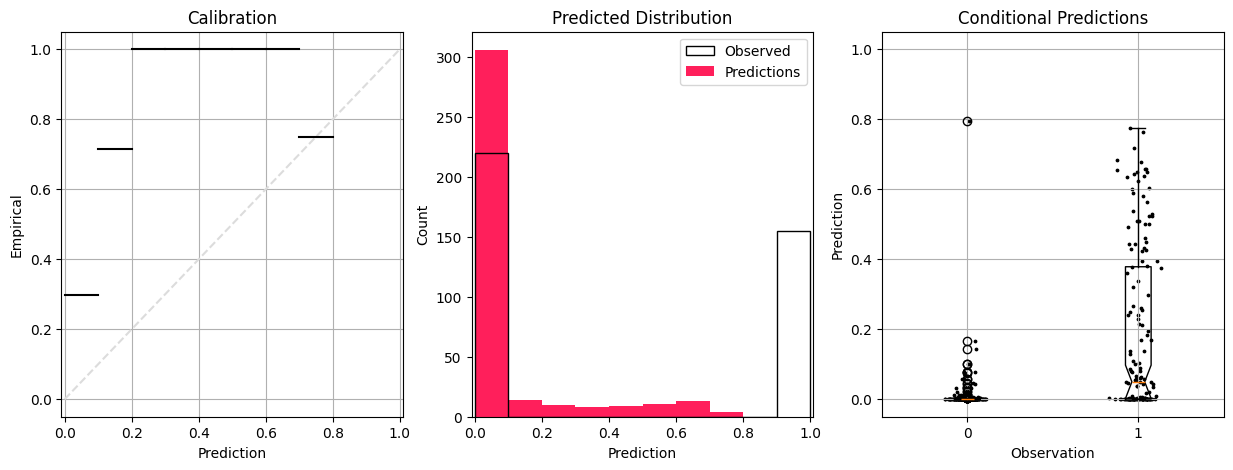

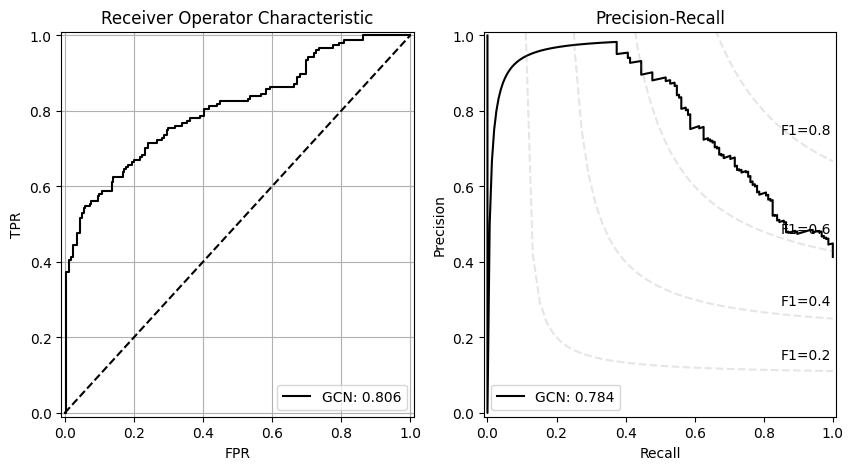

0.0 0.1 652
0.1 0.2 17
0.2 0.30000000000000004 10
0.30000000000000004 0.4 6
0.4 0.5 10
0.5 0.6000000000000001 8
0.6000000000000001 0.7000000000000001 9
0.7000000000000001 0.8 2
0.8 0.9 4
0.9 1.0 8


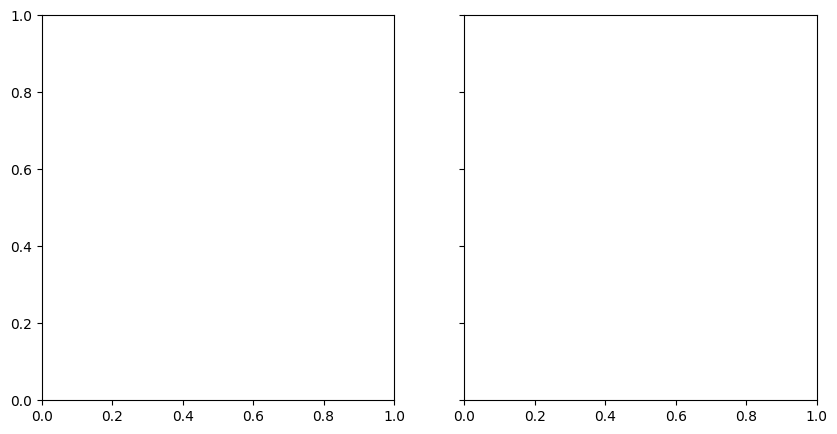

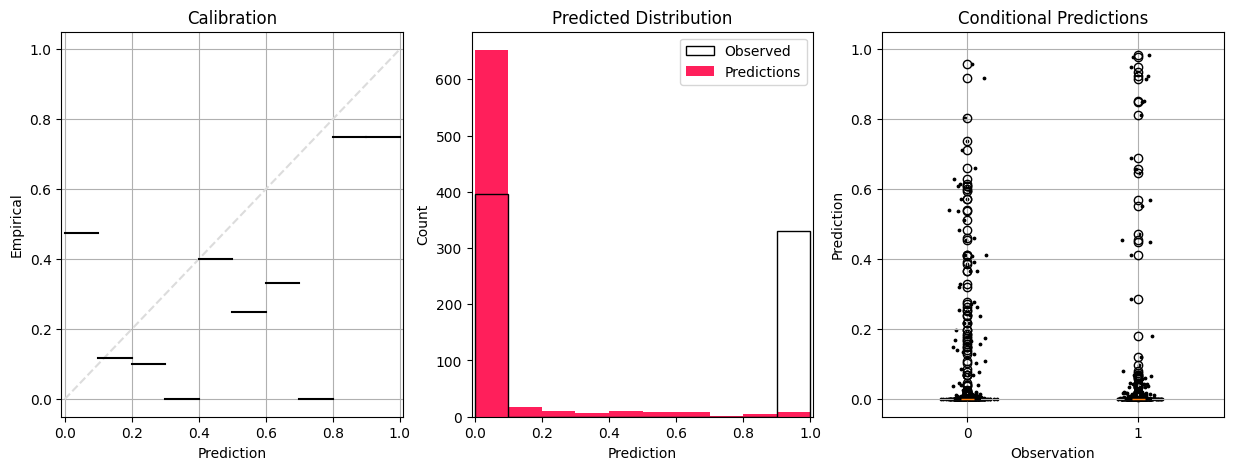

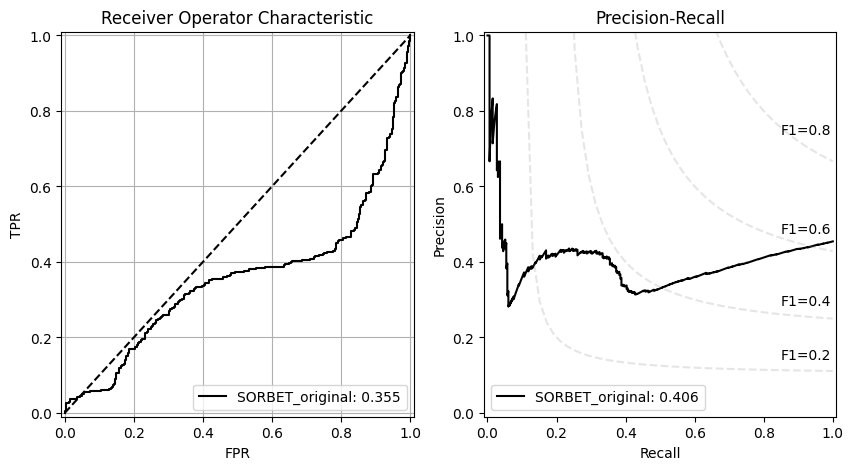

In [126]:
train_model_on_one_chort_and_test_on_the_other(1, "data/c{cnum}/original_subgraphs", "SORBET_original", 29)

2023-12-18 09:25:15,590	INFO tune.py:1148 -- Total run time: 1772.93 seconds (1772.88 seconds for the tuning loop).


{'epochs': 100, 'learning_rate': 0.00016327552661066317, 'batch_size': 64, 'restarts': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

Split 0 AUROC: 0.553
Split 1 AUROC: 0.611
Split 2 AUROC: 0.730
Split 3 AUROC: 0.255
Split 4 AUROC: 0.839


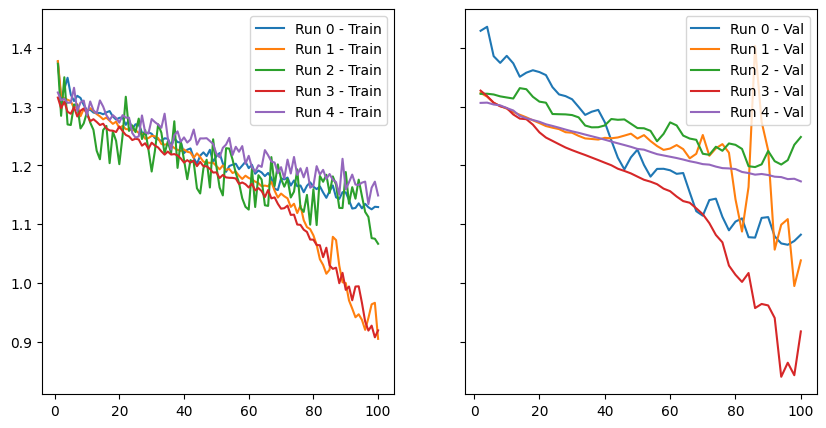

/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.0 0.1 0
0.1 0.2 12
0.2 0.30000000000000004 72
0.30000000000000004 0.4 114
0.4 0.5 128
0.5 0.6000000000000001 12
0.6000000000000001 0.7000000000000001 31
0.7000000000000001 0.8 6
0.8 0.9 0
0.9 1.0 0


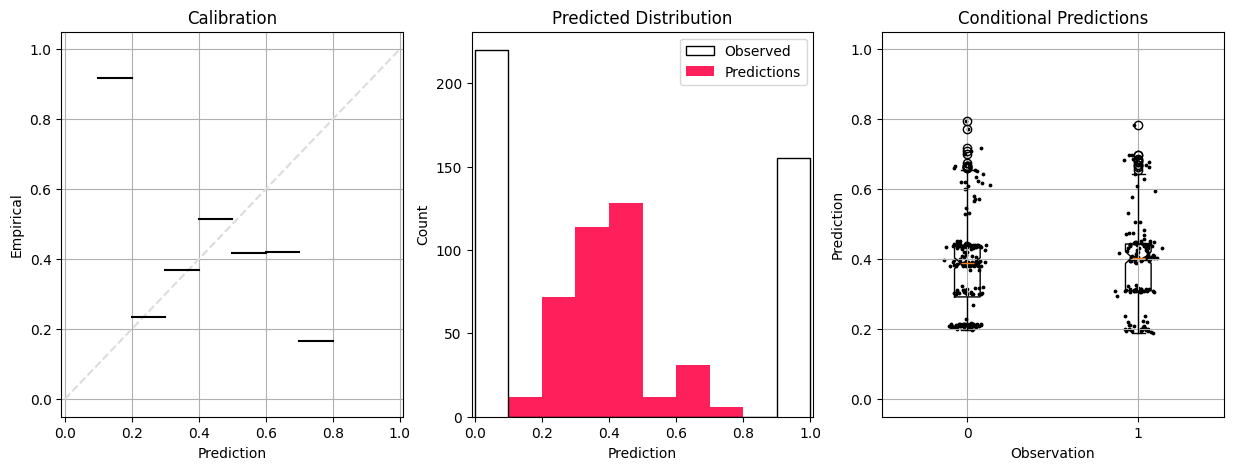

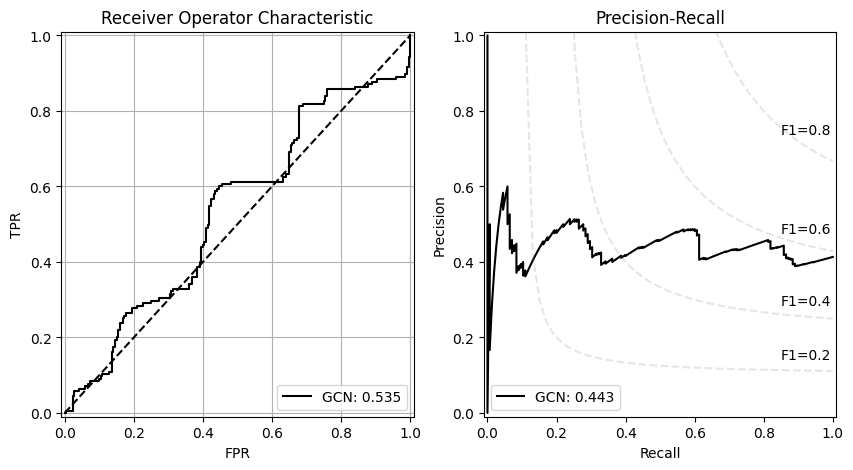

0.0 0.1 0
0.1 0.2 265
0.2 0.30000000000000004 10
0.30000000000000004 0.4 21
0.4 0.5 33
0.5 0.6000000000000001 45
0.6000000000000001 0.7000000000000001 100
0.7000000000000001 0.8 143
0.8 0.9 89
0.9 1.0 20


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


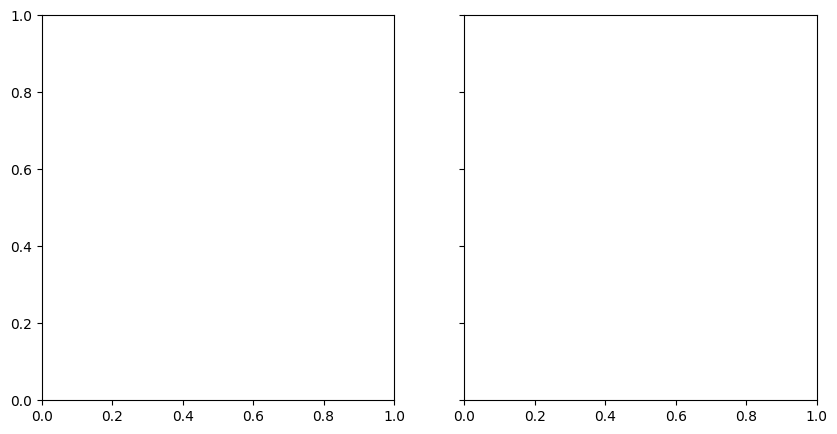

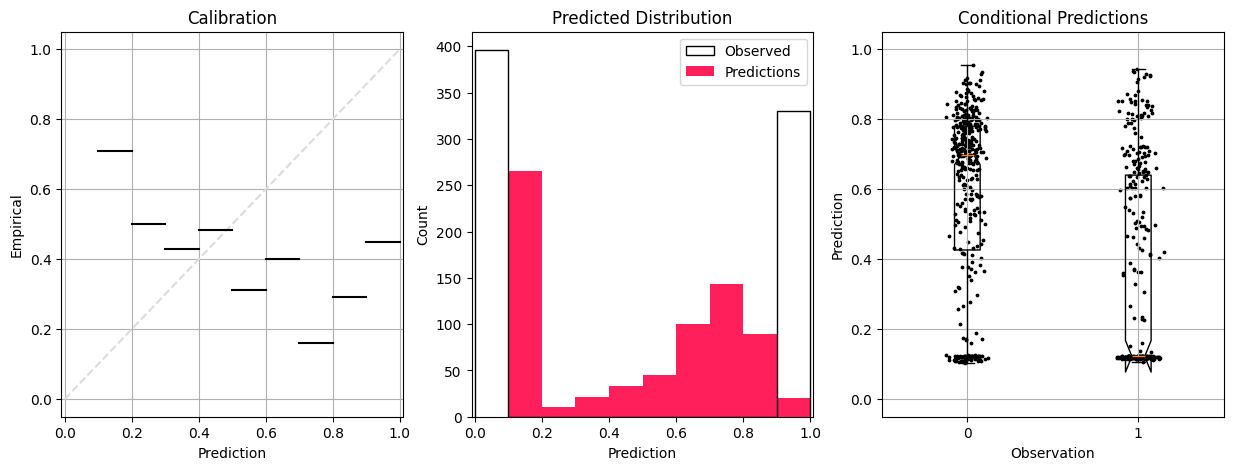

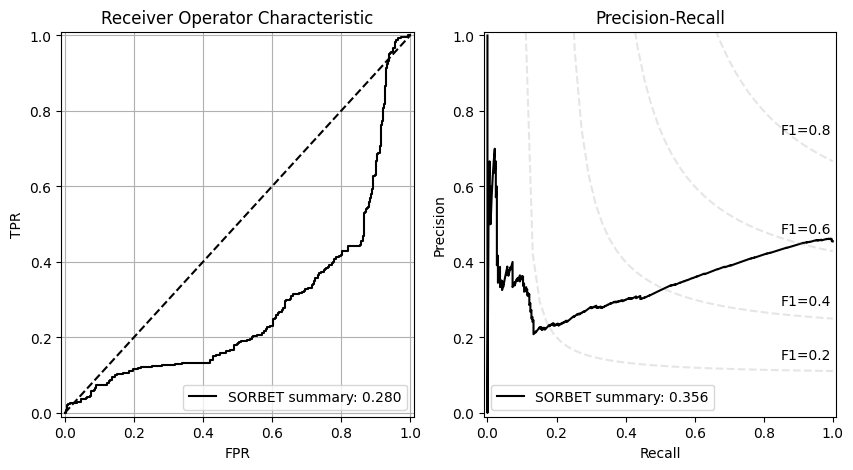

In [127]:
train_model_on_one_chort_and_test_on_the_other(1, "data/c{cnum}/summary_subgraphs", "SORBET summary", 768)

2023-12-18 10:02:54,658	INFO tune.py:1148 -- Total run time: 1931.75 seconds (1931.70 seconds for the tuning loop).


{'epochs': 100, 'learning_rate': 0.00010638694011037078, 'batch_size': 64, 'restarts': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

Split 0 AUROC: 0.709
Split 1 AUROC: 0.933
Split 2 AUROC: 0.618
Split 3 AUROC: 0.573
Split 4 AUROC: 0.019


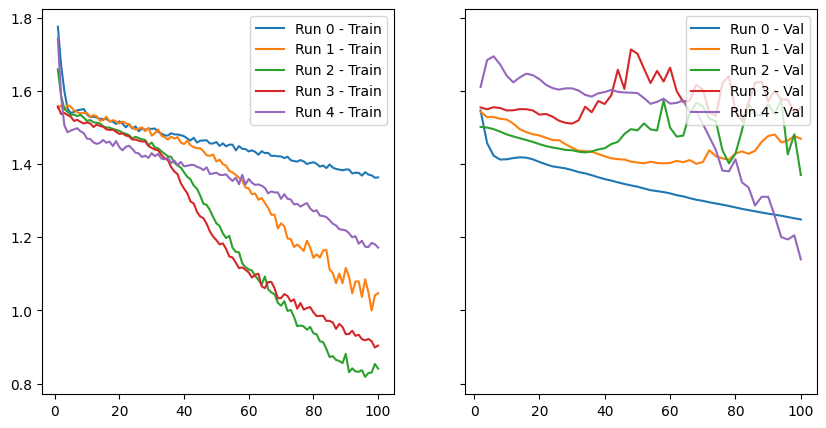

0.0 0.1 3
0.1 0.2 146
0.2 0.30000000000000004 122
0.30000000000000004 0.4 18
0.4 0.5 16
0.5 0.6000000000000001 13
0.6000000000000001 0.7000000000000001 26
0.7000000000000001 0.8 10
0.8 0.9 6
0.9 1.0 15


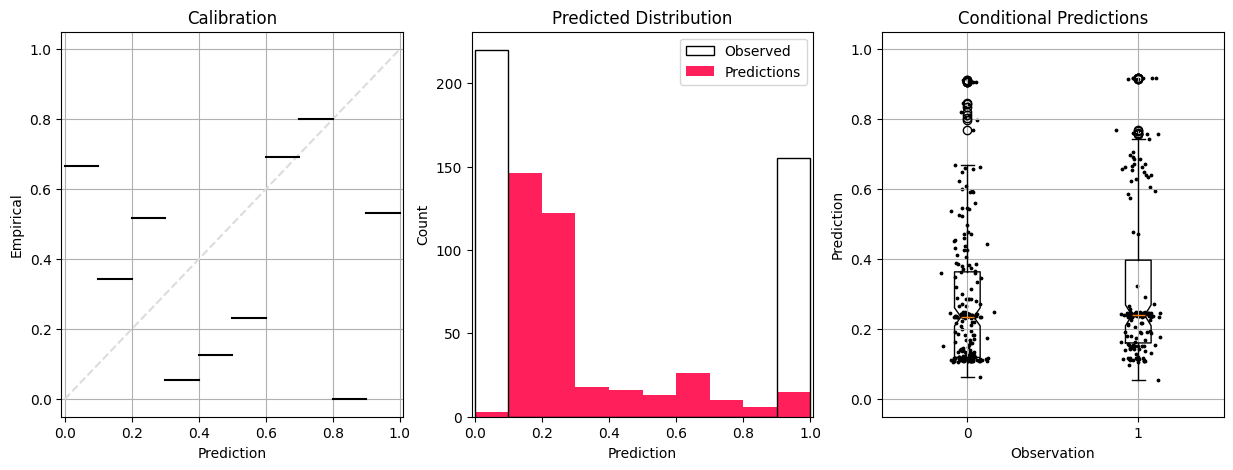

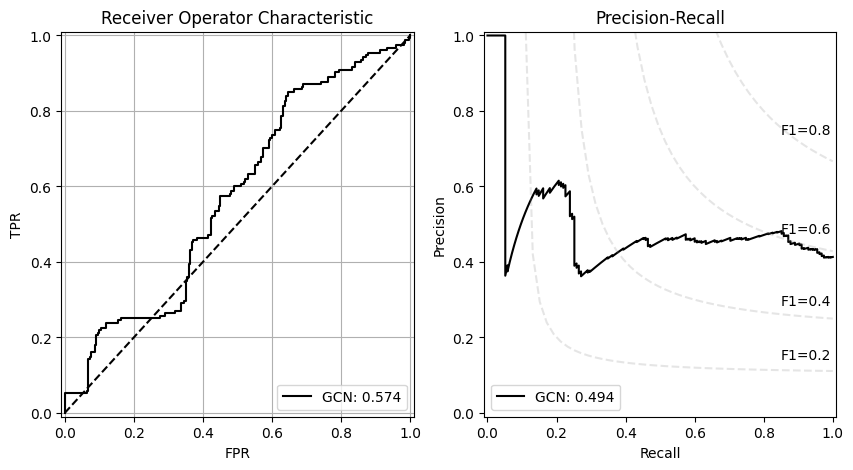

0.0 0.1 165
0.1 0.2 43
0.2 0.30000000000000004 68
0.30000000000000004 0.4 67
0.4 0.5 94
0.5 0.6000000000000001 87
0.6000000000000001 0.7000000000000001 54
0.7000000000000001 0.8 46
0.8 0.9 79
0.9 1.0 23


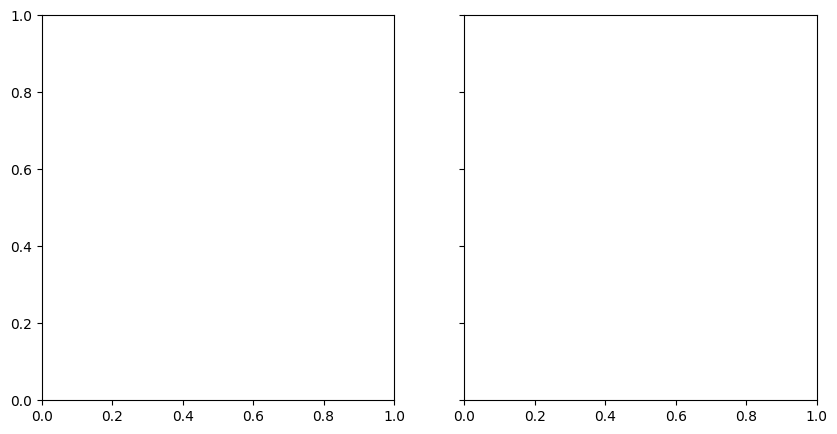

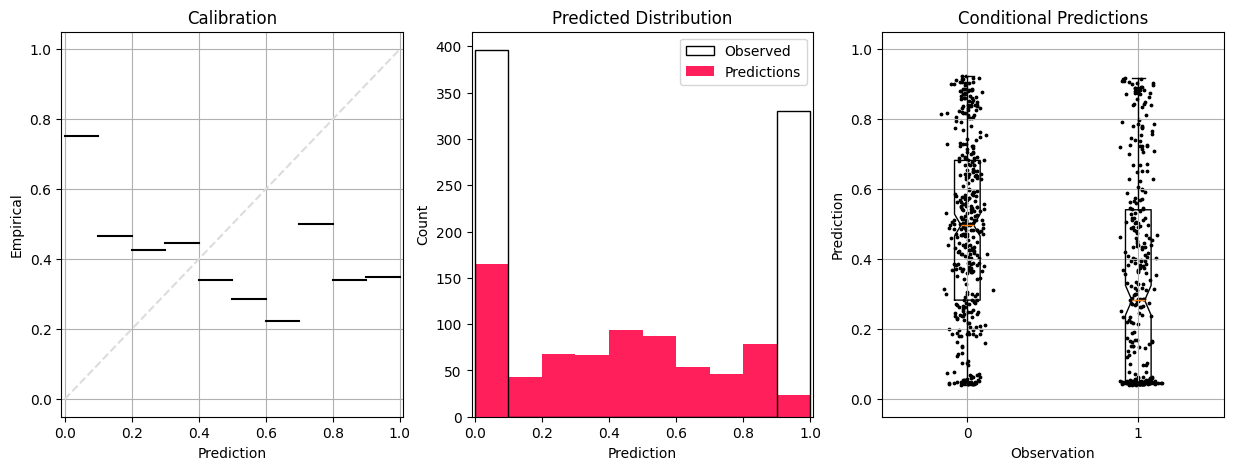

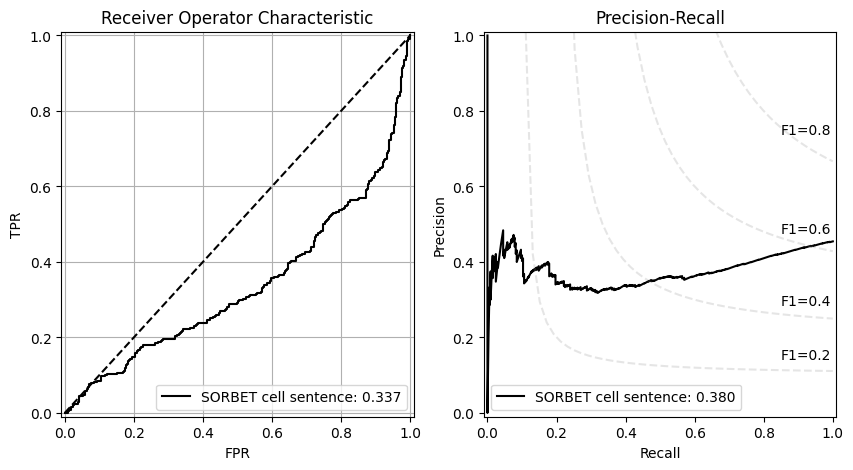

In [128]:
train_model_on_one_chort_and_test_on_the_other(1, "data/c{cnum}/cell_sentence_subgraphs", "SORBET cell sentence", 768)

2023-12-18 11:04:32,027	INFO tune.py:1148 -- Total run time: 3349.19 seconds (3349.14 seconds for the tuning loop).


{'epochs': 100, 'learning_rate': 0.00022219616053452957, 'batch_size': 64, 'restarts': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

Split 0 AUROC: 0.886
Split 1 AUROC: 0.240
Split 2 AUROC: 0.433
Split 3 AUROC: 0.771
Split 4 AUROC: 0.567


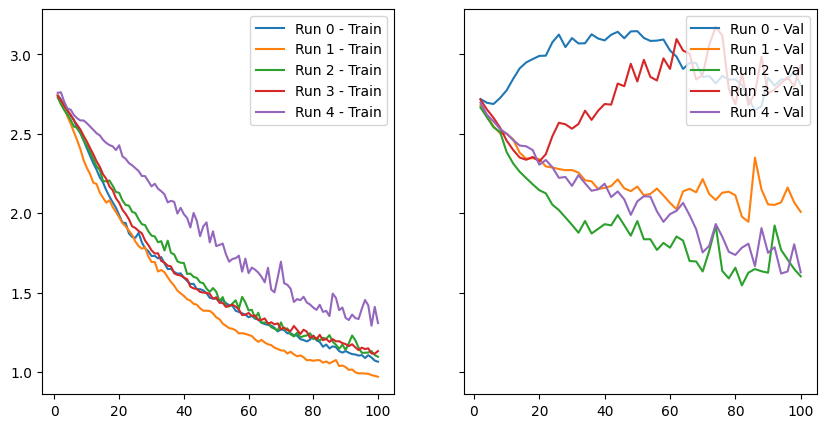

0.0 0.1 259
0.1 0.2 89
0.2 0.30000000000000004 32
0.30000000000000004 0.4 15
0.4 0.5 15
0.5 0.6000000000000001 24
0.6000000000000001 0.7000000000000001 24
0.7000000000000001 0.8 66
0.8 0.9 72
0.9 1.0 130


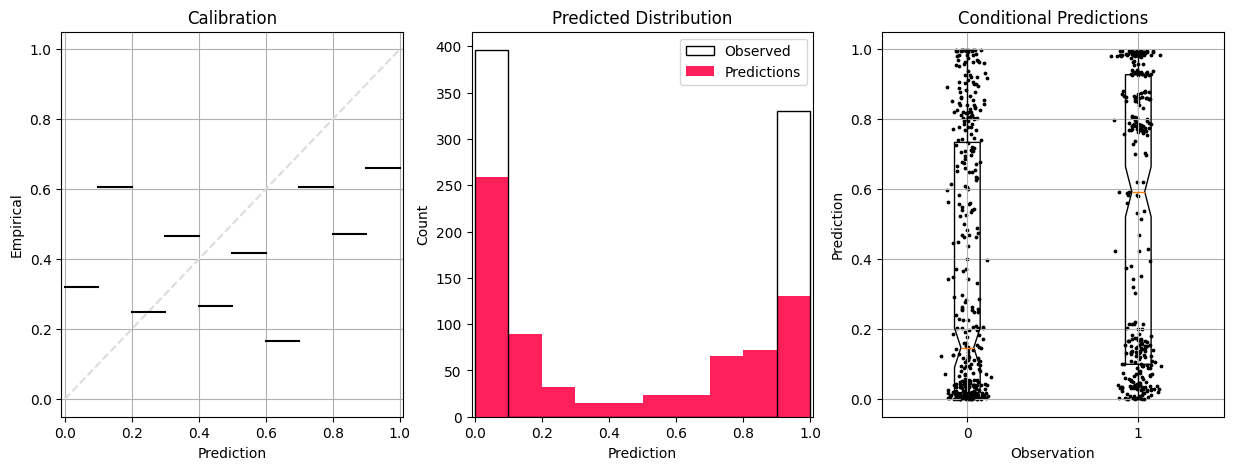

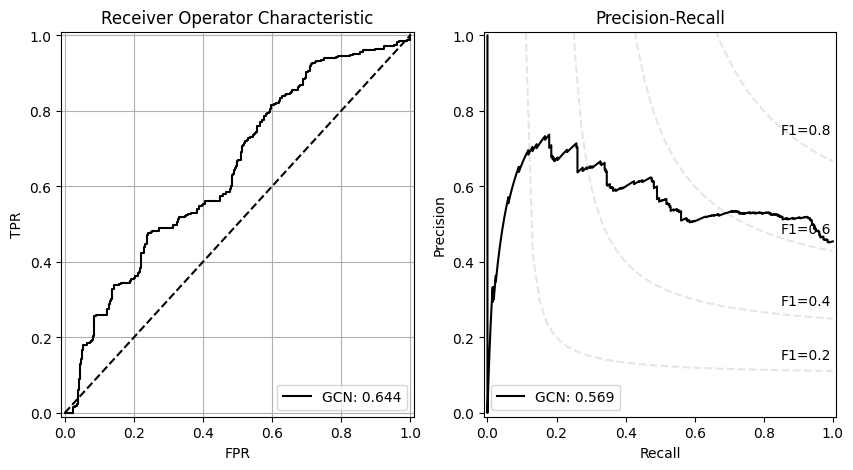

0.0 0.1 0
0.1 0.2 1
0.2 0.30000000000000004 2
0.30000000000000004 0.4 3
0.4 0.5 1
0.5 0.6000000000000001 1
0.6000000000000001 0.7000000000000001 2
0.7000000000000001 0.8 3
0.8 0.9 9
0.9 1.0 353


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


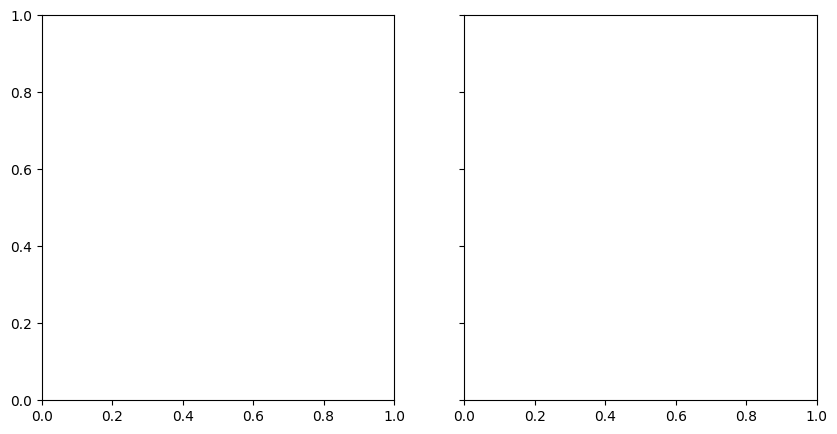

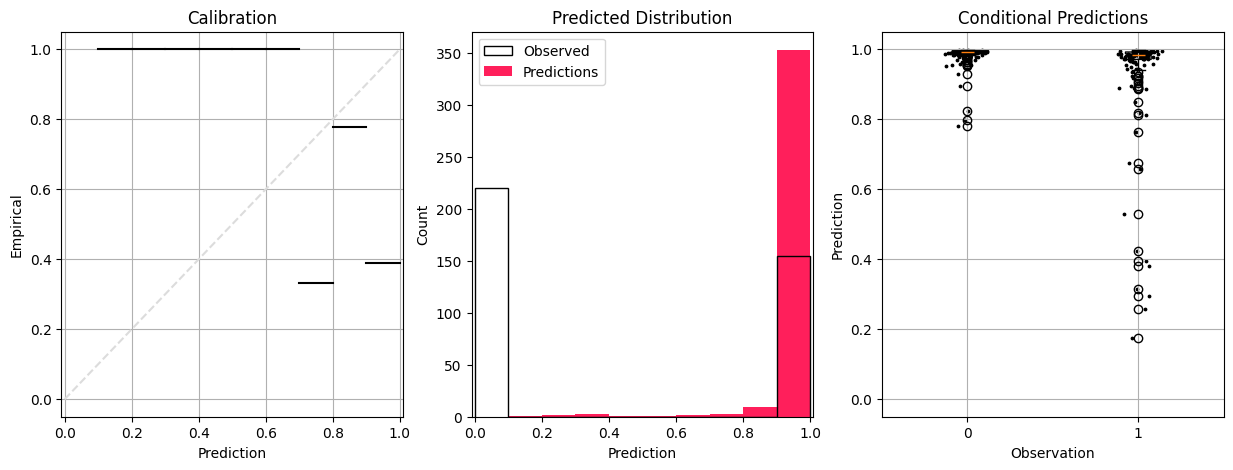

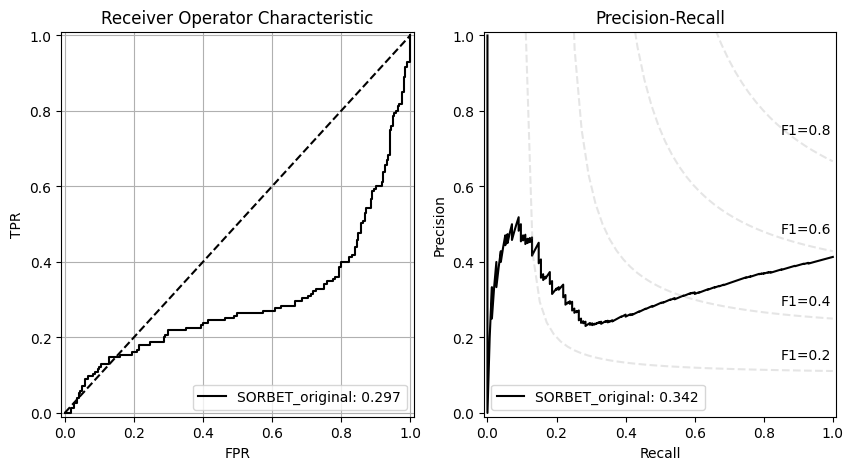

In [129]:
train_model_on_one_chort_and_test_on_the_other(2, "data/c{cnum}/original_subgraphs", "SORBET_original", 29)

2023-12-18 12:24:36,851	INFO tune.py:1148 -- Total run time: 4194.20 seconds (4194.16 seconds for the tuning loop).


{'epochs': 100, 'learning_rate': 0.0001954082112109821, 'batch_size': 64, 'restarts': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

Split 0 AUROC: 0.400
Split 1 AUROC: 0.958
Split 2 AUROC: 0.609
Split 3 AUROC: 0.536
Split 4 AUROC: 0.699


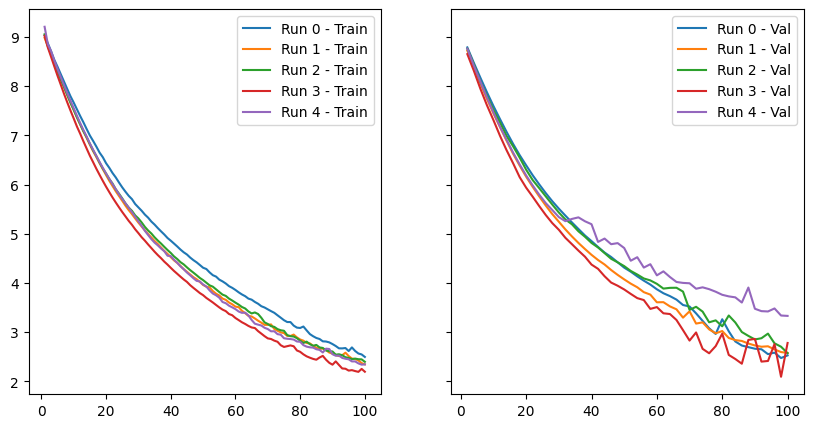

0.0 0.1 46
0.1 0.2 99
0.2 0.30000000000000004 129
0.30000000000000004 0.4 23
0.4 0.5 10
0.5 0.6000000000000001 4
0.6000000000000001 0.7000000000000001 3
0.7000000000000001 0.8 195
0.8 0.9 217
0.9 1.0 0


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


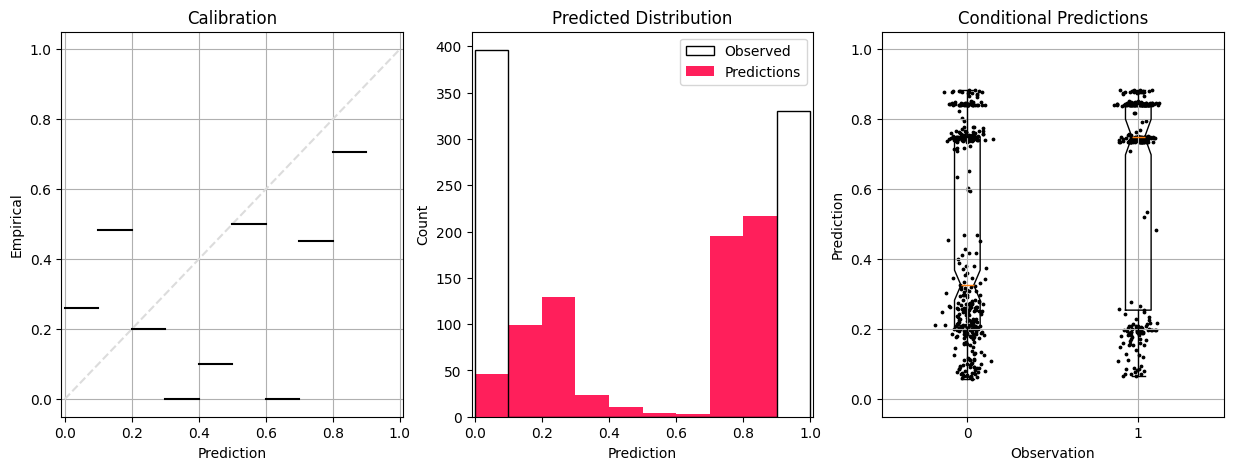

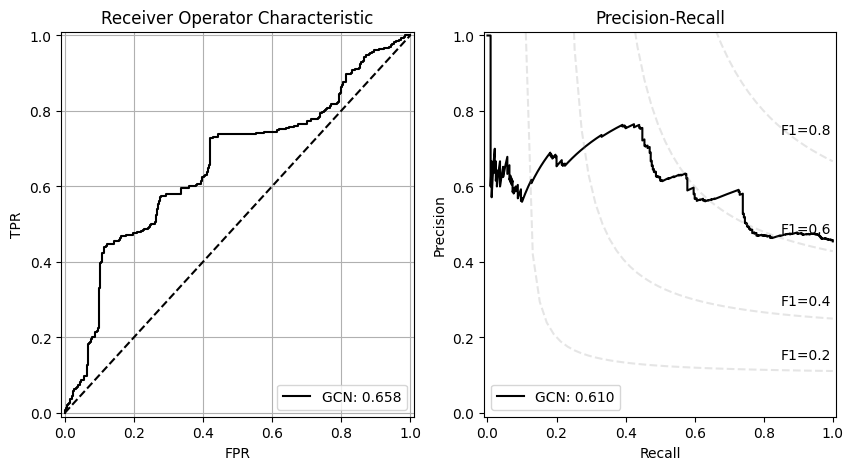

0.0 0.1 0
0.1 0.2 0
0.2 0.30000000000000004 0
0.30000000000000004 0.4 0
0.4 0.5 0
0.5 0.6000000000000001 0
0.6000000000000001 0.7000000000000001 0
0.7000000000000001 0.8 4
0.8 0.9 371
0.9 1.0 0


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


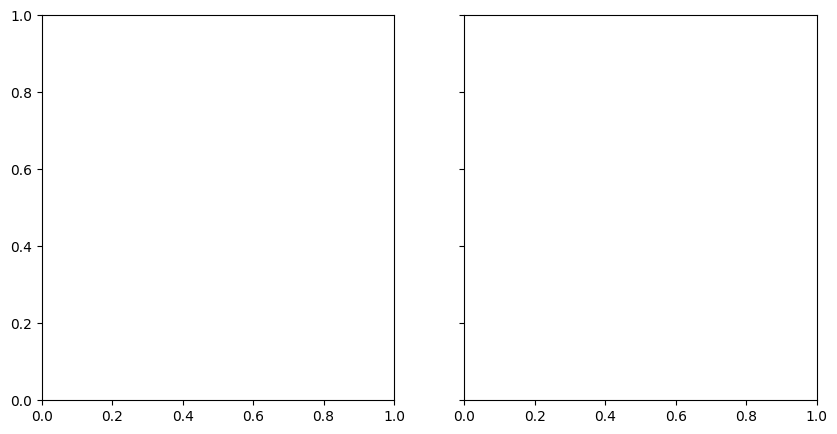

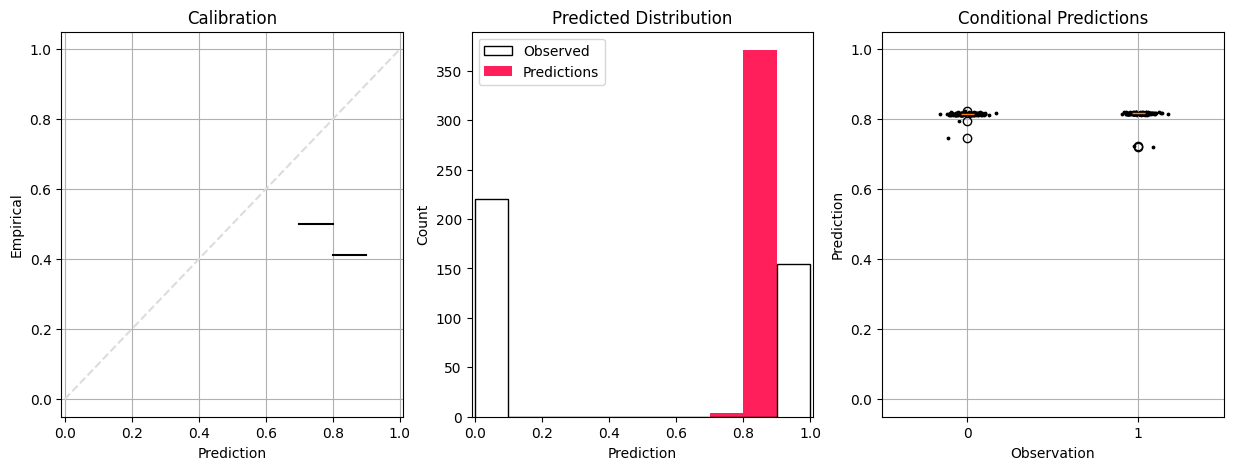

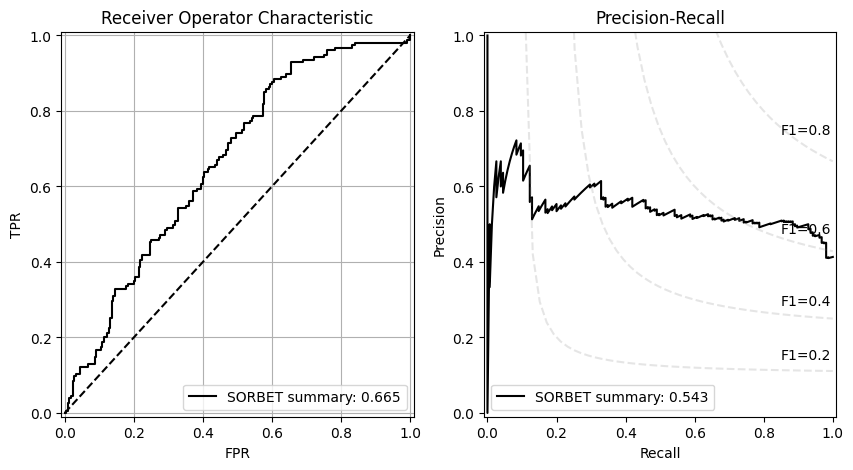

In [130]:
train_model_on_one_chort_and_test_on_the_other(2, "data/c{cnum}/summary_subgraphs", "SORBET summary", 768)

2023-12-18 13:50:04,716	INFO tune.py:1148 -- Total run time: 4542.03 seconds (4541.98 seconds for the tuning loop).


{'epochs': 100, 'learning_rate': 0.00010009708114339765, 'batch_size': 64, 'restarts': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

Split 0 AUROC: 0.695
Split 1 AUROC: 0.544
Split 2 AUROC: 0.523
Split 3 AUROC: 0.857
Split 4 AUROC: 0.586


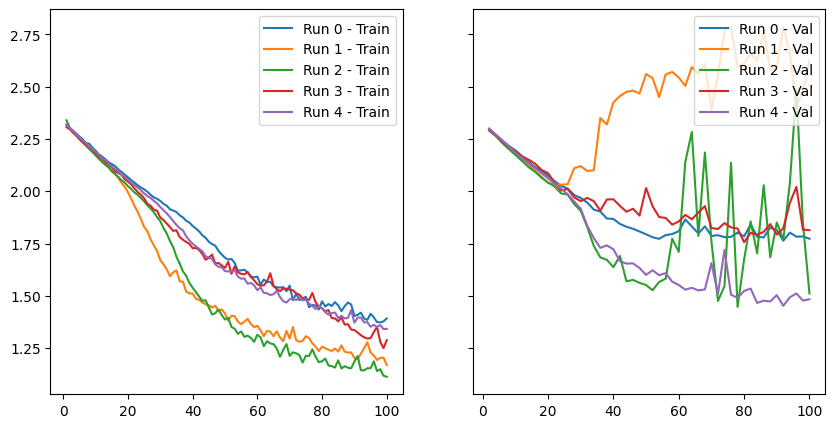

0.0 0.1 193
0.1 0.2 104
0.2 0.30000000000000004 48
0.30000000000000004 0.4 26
0.4 0.5 31
0.5 0.6000000000000001 23
0.6000000000000001 0.7000000000000001 16
0.7000000000000001 0.8 124
0.8 0.9 10
0.9 1.0 151


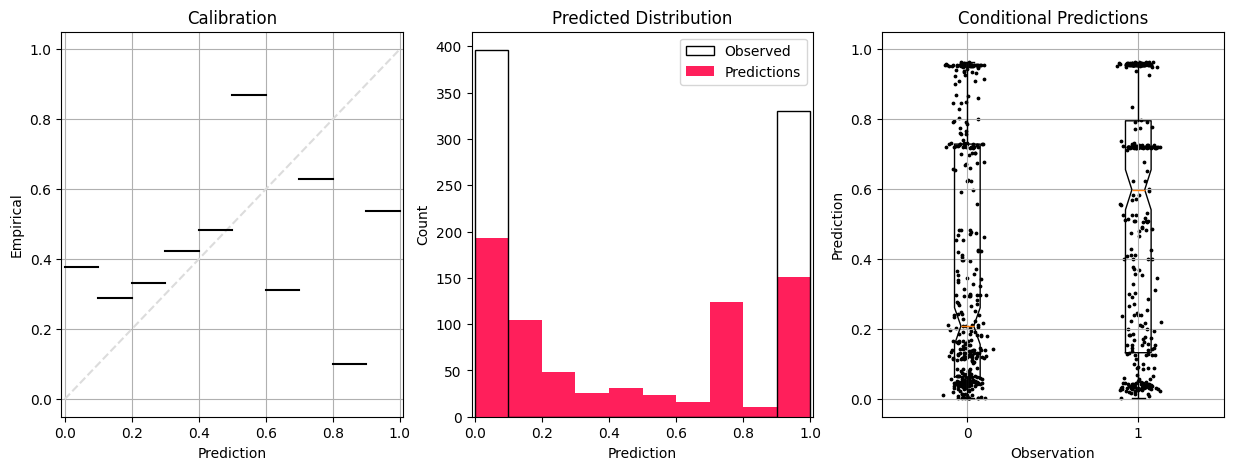

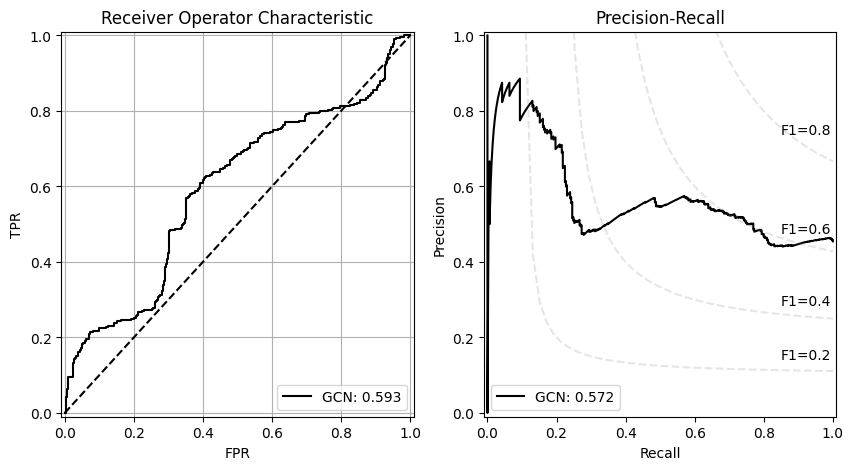

0.0 0.1 0
0.1 0.2 0
0.2 0.30000000000000004 5
0.30000000000000004 0.4 4
0.4 0.5 1
0.5 0.6000000000000001 2
0.6000000000000001 0.7000000000000001 1
0.7000000000000001 0.8 362
0.8 0.9 0
0.9 1.0 0


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


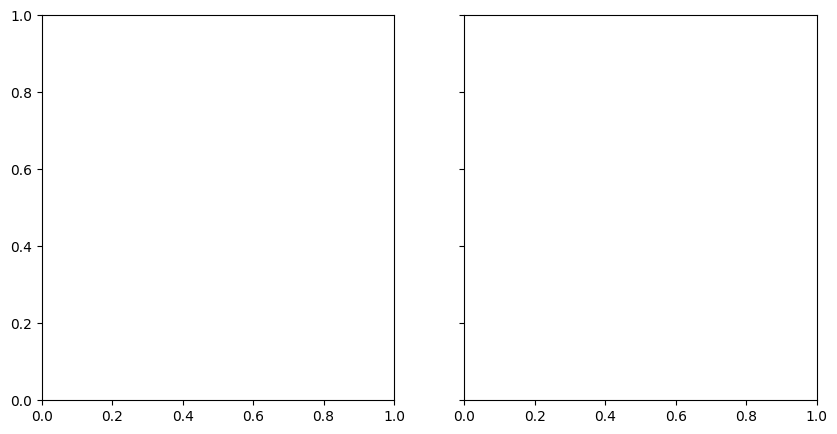

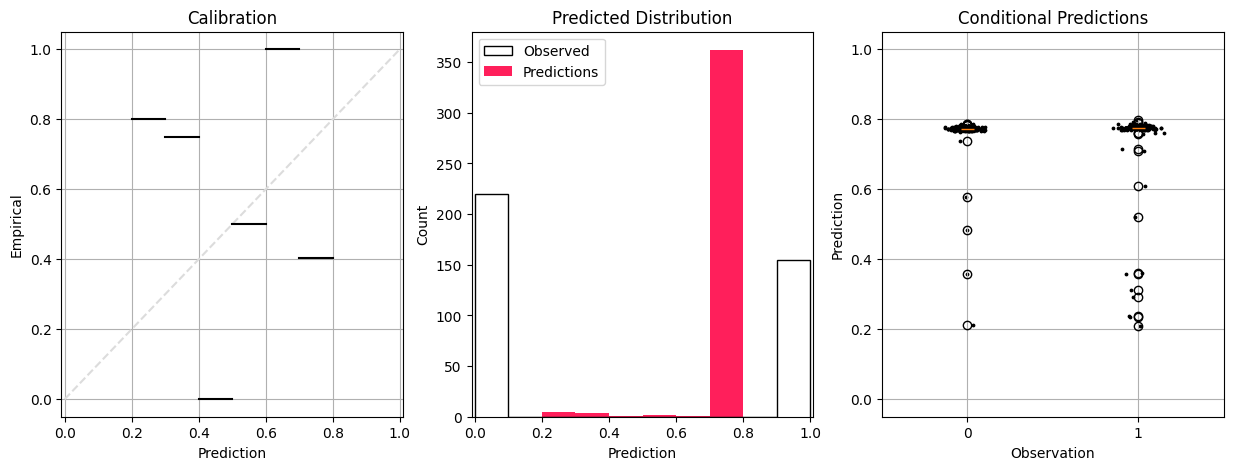

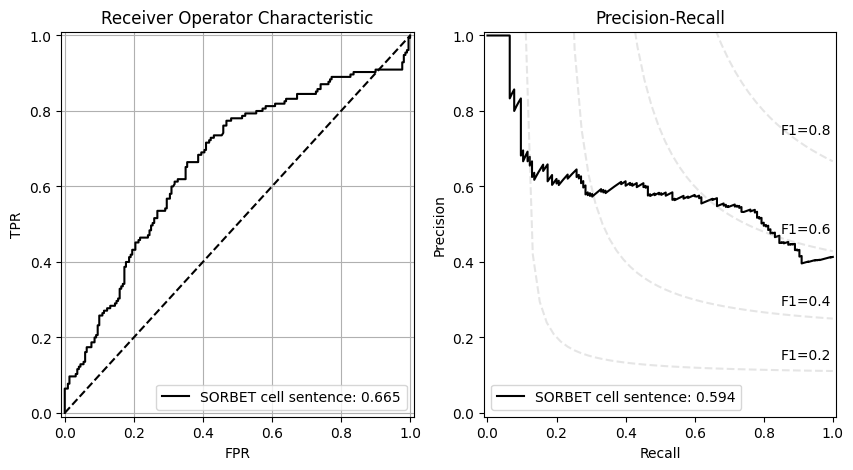

In [131]:
train_model_on_one_chort_and_test_on_the_other(2, "data/c{cnum}/cell_sentence_subgraphs", "SORBET cell sentence", 768)